# Implementation of the Discrete Empirical Interpolation Method (DEIM)

In [1]:
import numpy as np

In [38]:
def cur(A, idx=False, SVD=None):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    
    V,S,Wt = SVD
    rank = np.linalg.matrix_rank(A)
    
    def DEIM(M): # row/column selection
        p = []
        p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(1,rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt))
    C = A[:,p_C]
    
    p_R = DEIM(V)
    R = A[p_R]
    
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,U,R, p_C, p_R) if idx else (C,U,R)

## Example

In [3]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
print("A =",A)
C,U,R,p_C,p_R = cur(A, idx=True)
print("C =",C)
print("U =",U)
print("R =",R)
print("p_C =", p_C)
print("p_R =", p_R)

A = [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
C = [[ 3  1]
 [ 6  4]
 [ 9  7]
 [12 10]]
U = [[-0.05555556  0.55555556]
 [ 0.16666667 -0.66666667]]
R = [[10 11 12]
 [ 1  2  3]]
p_C = [2, 0]
p_R = [3, 0]


# Use DEIM on survey data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

## Load survey data

In [5]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel(path, sheet_name="Survey_32W", converters={'T3':str})

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
# Also drop rows mentioning question 60/62
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]') &
    (survey_32W['T3'] != 'no comments') &
    (survey_32W['T3'] != 'no comments.') &
    (survey_32W['T3'] != '0') &
    (survey_32W['T3'] != 'none.') &
    (survey_32W['T3'] != '[none]') &
    (survey_32W['T3'] != 'no comment') &
    (survey_32W['T3'] != 'No comments were made') &
    (survey_32W['T3'] != 'No Reason') &
    (survey_32W['T3'] != 'No reason.') &
    (survey_32W['T3'] != 'Same') &
    (survey_32W['T3'] != '12') &
    (survey_32W['T3'].str.contains('57') == False) &
    (survey_32W['T3'].str.contains('60') == False) &
    (survey_32W['T3'].str.contains('62') == False)]

# Split between those who answered same/separate outfits
res_same = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

## Embed responses

In [6]:
# Transpose so each column is one response
embed_same = np.transpose(model.encode(res_same))
embed_separate = np.transpose(model.encode(res_separate))

## Use DEIM to form a matrix of the "most important" responses

In [7]:
C_same,U_same,R_same, p_C_same, p_R_same = cur(embed_same, idx=True)
C_separate,U_separate,R_separate, p_C_separate, p_R_separate = cur(embed_separate, idx=True)

## Display top 20 responses of each category

In [8]:
print("Same\n")
for i in range(20):
    print(res_same[p_C_same[i]])
print("\nSeparate\n")
for i in range(20):
    print(res_separate[p_C_separate[i]])

Same

They would make better soldiers because they would be treated equal
it all right
Should have separate sleeping quarters, though
We all fight for same cause.
so they could learn to work together.
Because it takes all kinds of men to make an outfit
It's [unclear]one car, who[/unclear] should not make any difference, any good soldier could easily overlook that
But not in same room eating or sleeping.
Aren't we fighting this war to do away with theories of racial superiority
I think they should all stay together both comm. & non com.
The negroes I've seen could work with anybody. 
They both shed the same blood on the battlefront, and share the same thoughts and experiences
They fight just as hard as the white man
It's alright for them to be but they are good for truck driving & garbage men and so forth.
because be are brother and have as much heart as we have in our body.
Perhaps could be in the same regiment but in different companies.
But different barracks and different mess halls

## Cluster responses using top responses as centroids

In [9]:
def print_clusters(k,C,p_C,res):
    Ct = np.transpose(C)
    centroids = Ct[:k]
    kmeans = KMeans(n_clusters=k, init=centroids, n_init=1, max_iter=1).fit(Ct)
    for i in range(k):
        print("Cluster",i,"\n")
        print(*[res[p_C[j]] for j in range(len(kmeans.labels_)) if kmeans.labels_[j] == i], sep="\n")
        print()

In [10]:
print_clusters(10,C_same, p_C_same, res_same)

Cluster 0 

They would make better soldiers because they would be treated equal
Because after all we all are human being and that all that count?
I believe if they were trained with white soldiers they would [be] better soldiers.
They should be together-perhaps it is too early for that.
because if their fighting for the same cuuse should have the same privilegs is white
Negroes have higher spirits than Whites should help morale a lot.
It helps bring relationship - better understanding.
Negros can labor better in heat and bad conditions and the white men have the intelligence to operate more complicated machines
They are Americans the same as the white race.
Negro soldiers certainly could learn much from white concerning conduct and whites could become accustomed to colored association.
If separated each group would try to be better but this would cause jealousy and indifference.
Lessens infiror and superior complexes among the men of what is supposed to be a united people
This would he

In [11]:
print_clusters(30, C_separate, p_C_separate, res_separate)

Cluster 0 

A negro would be discriminated against in any white outfit and whites would resent being with them getting equal treatment.
Because I would not like to sleep by a Negro.
the boys from the South won't mix with the negro
because we don't like Negro are from oklahoma
I don't like Nigroes + most Northern boys don't so lots of discord could be avoided by entirely separating both.
They are a difference class and should not be with the white.
Prejudices against one another is bad for the moral.
I think they should give stripes to those men that it does not go to his head about them and not to those that play's foxcuts and the ones that deserves them.
Because some of the negro People are very Dirty and [unclear][/unclear]
Don't put negroes & whites in the same outfit -- you'll be getting into hot water.
we would not want a negro sgt or Lt. capt or what not to give us white order
I believe the negroes would feel out of place in that case
Lowers standard of the white men. Let negro t

# Best rank-k approximation

In [43]:
def plot_eta_c(A):
    V,S,Wt = np.linalg.svd(A)
    rank = np.linalg.matrix_rank(A)
    
    eta_c = np.zeros(rank)
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        A_k = np.add(A_k, S[k] * np.outer(V[:,k], Wt[k,:]))
        SVD_k = np.linalg.svd(A_k) # (V[:,:k+1],S[:k+1],Wt[:k+1,:])
        C_k, U_k, R_k, p_C_k, p_R_k = cur(A_k, idx=True, SVD=SVD_k)
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]] #Wt?
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        
    plt.scatter(range(rank), eta_c)

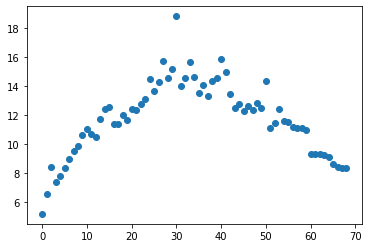

In [44]:
plot_eta_c(embed_same)

In [45]:
plot_eta_c(embed_separate)

KeyboardInterrupt: 